<a href="https://colab.research.google.com/github/Rajatavaa/fine-tune-paligemma/blob/update-vanilla-requirements/notebooks/vanilla_paligemma_ft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/nb-covers.png)

In [1]:
# @title Setup and Imports
! pip install -U -q transformers accelerate datasets
import os
os.environ["TRANSFORMERS_VERBOSITY"] = "error"
import re
import numpy as np
from matplotlib import pyplot as plt

from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Configuration

In [2]:
dataset_id = "diffusers/tuxemon"
model_id = "google/paligemma-3b-pt-224"

device = "cuda:0"
dtype = torch.bfloat16

batch_size = 2
learning_rate = 1e-5

## Dataset for Fine Tuning

In [3]:
dataset = load_dataset(dataset_id, split="train")
dataset = dataset.train_test_split(test_size=0.3)

train_dataset = dataset["train"]
val_test_dataset = dataset["test"].train_test_split(test_size=0.2)

val_dataset = val_test_dataset["train"]
test_dataset = val_test_dataset["test"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/44.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/251 [00:00<?, ? examples/s]

In [5]:
from huggingface_hub import notebook_login
notebook_login()
processor = AutoProcessor.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

In [6]:
# @title Create Data Loader
def collate_train_fn(examples):
    images = [example["image"].convert("RGB") for example in examples]

    prompt = ["Caption the image." for _ in examples]
    suffix = [example["blip_caption"] for example in examples]

    # Help from: https://github.com/huggingface/transformers/issues/30987
    inputs = processor(
        images=images,
        text=prompt,
        suffix=suffix,
        return_tensors="pt",
        padding="longest",
    )

    inputs = inputs.to(torch.bfloat16).to(device)
    return inputs


def collate_test_fn(examples):
    images = [example["image"].convert("RGB") for example in examples]

    prompt = ["Caption the image." for _ in examples]

    inputs = processor(
        images=images,
        text=prompt,
        return_tensors="pt",
        padding="longest",
    )

    inputs = inputs.to(torch.bfloat16).to(device)
    return inputs


train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_train_fn,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    collate_fn=collate_train_fn,
    batch_size=batch_size,
    shuffle=False,
)

test_dataloader = DataLoader(
    test_dataset,
    collate_fn=collate_test_fn,
    batch_size=batch_size,
    shuffle=False,
)

## Model creation

In [7]:
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
    revision="bfloat16",
)

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
# Total trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Trainable attention layer parameters
attn_params = sum(
    p.numel() for name, p in model.named_parameters()
    if p.requires_grad and "attn" in name
)

print(f"Total trainable parameters: {total_params}")
print(f"Trainable attention parameters: {attn_params}")




Total trainable parameters: 2923466480
Trainable attention parameters: 313320960


In [8]:
# @title Freezing everything but the attention layers

for name, param in model.named_parameters():
    if "attn" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

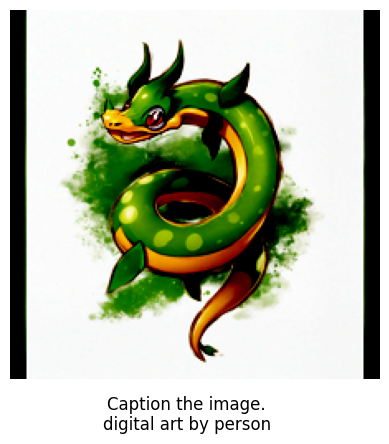

In [ ]:
# @title Results _before_ Fine Tuning

test_batch = next(iter(test_dataloader))

index = 0

plt.imshow(test_batch["pixel_values"][index].permute(1, 2, 0).cpu().to(torch.float32))
plt.axis("off")

generated_outputs = model.generate(
    **test_batch,
    max_new_tokens=30,
)
generated_outputs = processor.batch_decode(
    generated_outputs, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[index]

plt.figtext(
    0.5, 0.01, generated_outputs, wrap=True, horizontalalignment="center", fontsize=12
)

plt.show()

## Fine tune the model

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = model.to(torch.bfloat16)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,weight_decay = 1e-3)
scheduler = ReduceLROnPlateau(optimizer,mode='min', factor=0.5, patience=2,verbose=True )

model.train()

for epoch in range(10):
    total_train_loss = 0
    # Training Loop
    for idx, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        if idx % 10 == 0:
            print(f"Epoch: {epoch+1} Iter: {idx} Train Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_outputs = model(**val_batch)
            val_loss = val_outputs.loss
            total_val_loss += val_loss.item()

    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(val_dataloader)
    scheduler.step(avg_val_loss)

    for param_group in optimizer.param_groups:
      print(f"Epoch {epoch+1} | Avg Train Loss: {avg_train_loss:.4f} | Avg Val Loss: {avg_val_loss:.4f} Learning Rate: {param_group['lr']:.6f}\n")

    model.train()


Epoch: 1 Iter: 0 Train Loss: 4.0791
Epoch: 1 Iter: 10 Train Loss: 3.4445
Epoch: 1 Iter: 20 Train Loss: 2.4486
Epoch: 1 Iter: 30 Train Loss: 1.7000
Epoch: 1 Iter: 40 Train Loss: 1.2706
Epoch: 1 Iter: 50 Train Loss: 0.7275
Epoch: 1 Iter: 60 Train Loss: 1.2191
Epoch: 1 Iter: 70 Train Loss: 1.4082
Epoch: 1 Iter: 80 Train Loss: 1.4832
Epoch 1 | Avg Train Loss: 1.6076 | Avg Val Loss: 0.8287 Learning Rate: 0.000010

Epoch: 2 Iter: 0 Train Loss: 0.9143
Epoch: 2 Iter: 10 Train Loss: 1.1069
Epoch: 2 Iter: 20 Train Loss: 0.6061
Epoch: 2 Iter: 30 Train Loss: 1.0825
Epoch: 2 Iter: 40 Train Loss: 0.4921
Epoch: 2 Iter: 50 Train Loss: 0.4656
Epoch: 2 Iter: 60 Train Loss: 0.8145
Epoch: 2 Iter: 70 Train Loss: 0.3051
Epoch: 2 Iter: 80 Train Loss: 0.9558
Epoch 2 | Avg Train Loss: 0.7120 | Avg Val Loss: 0.7816 Learning Rate: 0.000010

Epoch: 3 Iter: 0 Train Loss: 1.2357
Epoch: 3 Iter: 10 Train Loss: 0.7874
Epoch: 3 Iter: 20 Train Loss: 0.7858
Epoch: 3 Iter: 30 Train Loss: 1.1159
Epoch: 3 Iter: 40 Train Los

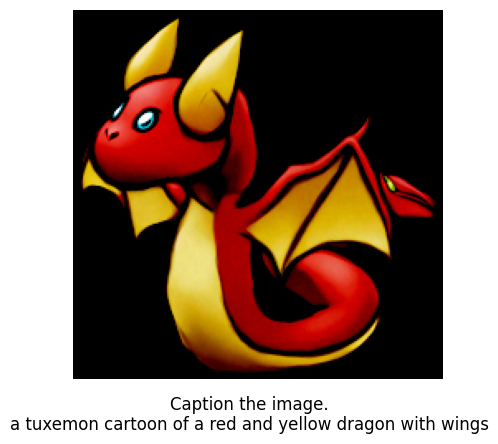

In [12]:
# Get a batch from the DataLoader
test_batch = next(iter(test_dataloader))

index =0  # Replace with the desired index within the batch
pixel_values = test_batch["pixel_values"][index]

# Display the image
plt.imshow(pixel_values.permute(1, 2, 0).cpu().to(torch.float32))
plt.axis("off")

# Generate outputs
generated_outputs = model.generate(
    **test_batch,
    max_new_tokens=30,
)
generated_outputs = processor.batch_decode(
    generated_outputs, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[index]

# Display results
plt.figtext(
    0.5, 0.01, generated_outputs, wrap=True, horizontalalignment="center", fontsize=12
)
plt.show()
